In [1]:
# !pip install --quiet optuna
# !pip install --quiet stellargraph

In [2]:
import os
import optuna
from optuna.trial import TrialState

/home/mohit/anaconda3/envs/btp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import numpy as np
import torch
import random
import math
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from torch.utils.data import DataLoader, TensorDataset

# Data prep

In [5]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('../Data/grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [6]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # only PM2_5
    df = df[['dateTime','lat','long','pm2_5']]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [7]:
df = data_preparation('../PM Datasets/2020-12-01_all.csv')

In [8]:
def train_test_split(df, grid_points_indices, train_size):
    # random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [9]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [10]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [11]:
def prepare_train_data(df, grid_points_indices, train_size = 0.8):
    train_data, test_data = train_test_split(df, grid_points_indices, train_size)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

# Training

In [12]:
def my_loss(y_true, y_pred):
    loss = torch.mean((y_pred[y_true>0]-y_true[y_true>0])**2)
    return loss

In [13]:
def eval_model(model, testX, testY):
    output = model(torch.Tensor(testX))
    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)
    ## Rescale model predicted values
    test_output = np.array((output.detach().numpy() * (max_pm - min_pm)) + min_pm)
    # # Masked predicted values\
    mask_test = torch.sign(torch.Tensor(testY))
    test_output = torch.Tensor(test_output)*(mask_test)
    test_mse = my_loss(torch.Tensor(test_true), torch.Tensor(test_output))
    test_rmse = torch.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [14]:
def get_out_df(train_rmse, validation_rmse):
    max_pm = train_data.max()
    min_pm = train_data.min()
    scale_factor = max_pm - min_pm
    df = pd.DataFrame()
    df['Mean Train loss'] = [sum(train_rmse)*scale_factor/len(train_rmse)]
    df['Last Train loss'] = [train_rmse[-1]*scale_factor]
    df['Mean Test loss'] = [sum(validation_rmse)*scale_factor/len(validation_rmse)]
    df['Last Test loss'] = [validation_rmse[-1]*scale_factor]
    # df['Train time callbacks'] = [sum(cb.logs)]
    return df

In [15]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Initialize The Model

In [16]:
df = data_preparation('../dataset/Dec/2020-12-1_all.csv')
for i in range(2, 8):
    datafile = '../dataset/Dec/2020-12-'
    datafile +=  str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)

In [17]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.86)

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)


In [18]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(33, 270, 3) (33, 270) (3, 270, 3) (3, 270)


In [19]:
trainX[0].shape, trainY[0].shape, trainX.shape, trainY.shape

((270, 3), (270,), (33, 270, 3), (33, 270))

In [20]:
from gcn_lstm_gpu import GCN_LSTM
import numpy as np
import torch
adj = adj.astype(np.float32)
model=GCN_LSTM(torch.from_numpy(adj), grid_size = 270, seq_len = 3, gc_sizes = [4, 4], lstm_sizes = [4])
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-05)

2022-09-14 11:22:18.584133: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 11:22:18.585108: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
for param in model.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([270, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([270])


In [22]:

def train_model(model, optimizer, trainX, trainY, testX, testY, n_epochs, batch_size):
    # convert all data to tensor
    trainX = torch.from_numpy(trainX.astype(np.float32)).to(device)
    trainY = torch.from_numpy(trainY.astype(np.float32)).to(device)
    testX = torch.from_numpy(testX.astype(np.float32)).to(device)
    testY = torch.from_numpy(testY.astype(np.float32)).to(device)
    
    trainDs = TensorDataset(trainX, trainY)
    testDs = TensorDataset(testX, testY)
    trainLoader = DataLoader(trainDs, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(testDs, batch_size=batch_size, shuffle=False)

    train_mse, train_rmse, validation_mse, validation_rmse=[], [], [], []
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        for _, (inputs, targets) in enumerate(trainLoader):
            model.train()
            outputs = model(inputs)
            loss = my_loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(inputs)
        
        with torch.no_grad():
            for _, (inputs, targets) in enumerate(testLoader):
                model.eval()
                outputs = model(inputs)
                loss = my_loss(outputs, targets)
                valid_loss += loss.item()*len(inputs)

        train_loss /= len(trainX)
        valid_loss /= len(testX)
        train_mse.append(train_loss)
        validation_mse.append(valid_loss)
        train_rmse.append(math.sqrt(train_loss))
        validation_rmse.append(math.sqrt(valid_loss))

        if((epoch+1)%10==0):
            print(f'Epoch {epoch+1} \t Train Loss: ', {train_loss}, 'Valid Loss: ', {valid_loss})

    return train_mse, train_rmse, validation_mse, validation_rmse

Epoch 10 	 Train Loss:  {0.0209218387238004} Valid Loss:  {0.014028700068593025}
Epoch 20 	 Train Loss:  {0.016539232777149387} Valid Loss:  {0.013162948191165924}
Epoch 30 	 Train Loss:  {0.016191471396296314} Valid Loss:  {0.012912632897496223}
Epoch 40 	 Train Loss:  {0.015062144167269722} Valid Loss:  {0.012641048058867455}
Epoch 50 	 Train Loss:  {0.014856036526687218} Valid Loss:  {0.012649820186197758}
Epoch 60 	 Train Loss:  {0.015159583086091461} Valid Loss:  {0.012676592916250229}
Epoch 70 	 Train Loss:  {0.014766555646377983} Valid Loss:  {0.01264781504869461}
Epoch 80 	 Train Loss:  {0.014456766798640743} Valid Loss:  {0.012322380207479}
Epoch 90 	 Train Loss:  {0.014619499134520689} Valid Loss:  {0.01257316954433918}
Epoch 100 	 Train Loss:  {0.015042127956720915} Valid Loss:  {0.012688995338976383}
Epoch 110 	 Train Loss:  {0.014192040614557989} Valid Loss:  {0.012250206433236599}
Epoch 120 	 Train Loss:  {0.014971766366877338} Valid Loss:  {0.012532993219792843}
Epoch 13

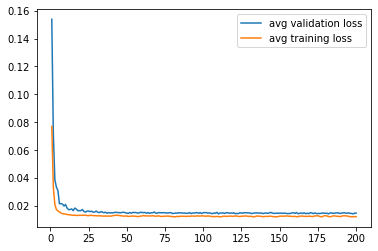

Mean Train loss  Last Train loss  Mean Test loss  Last Test loss
0        81.129618        78.108295       73.313097       71.014659

In [23]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 200, 5)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 201), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 201), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

Epoch 10 	 Train Loss:  {0.014190989292480728} Valid Loss:  {0.012554585002362728}
Epoch 20 	 Train Loss:  {0.014171989041973244} Valid Loss:  {0.012479833327233791}
Epoch 30 	 Train Loss:  {0.014449079887885036} Valid Loss:  {0.012438338249921799}
Epoch 40 	 Train Loss:  {0.014749839986589823} Valid Loss:  {0.012321624904870987}
Epoch 50 	 Train Loss:  {0.01464884891880281} Valid Loss:  {0.012306805700063705}
Epoch 60 	 Train Loss:  {0.014696766057926598} Valid Loss:  {0.012531878426671028}
Epoch 70 	 Train Loss:  {0.014196551884665634} Valid Loss:  {0.012389169074594975}
Epoch 80 	 Train Loss:  {0.014689957807687197} Valid Loss:  {0.012321455404162407}
Epoch 90 	 Train Loss:  {0.014808785791198412} Valid Loss:  {0.012259986251592636}
Epoch 100 	 Train Loss:  {0.014732921750030735} Valid Loss:  {0.012469111941754818}


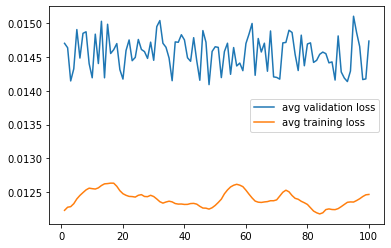

Mean Train loss  Last Train loss  Mean Test loss  Last Test loss
0        77.583591        78.062029       71.628658       71.814667

In [24]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

In [25]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

TypeError: train_model() missing 1 required positional argument: 'batch_size'

In [ ]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)